###**Understanding the Power of Transfer Learning AKA Pre-Trained Model**

**Importing Libraries**

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

**Download Dataset**

The following dataset is available on the fast.ai Datasets under the name Imagewoof

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./imagewoof2-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/imagewoof2-160'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['val', 'train']
['n02111889', 'n02087394', 'n02115641', 'n02093754', 'n02086240', 'n02099601', 'n02105641', 'n02096294', 'n02089973', 'n02088364']


**Transformations**

In [4]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(160, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize([160,160]),tt.ToTensor(), tt.Normalize(*stats)])

**Creating Datasets**

In [6]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/val', valid_tfms)
print(f'Length of training dataset = {len(train_ds)}')
print(f'Length of validation dataset = {len(valid_ds)}')

Length of training dataset = 9025
Length of validation dataset = 3929


**Batch Size**

In [7]:
batch_size = 64

**Creating Data Loader**

In [8]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

**Sample images from the training dataloader**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


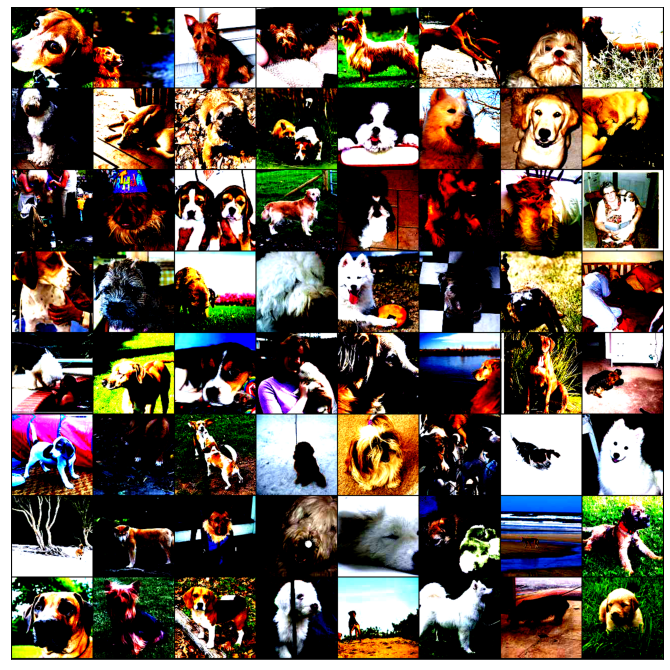

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

**Using GPU**

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

**Moving Dataloaders to Device**

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


**Defing Model**

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

**Pre-Trained Model Class**

In [14]:
class Resnet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [15]:
model = to_device(Resnet50(), device)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Resnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

**Defining Training functions**

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.14340001344680786, 'val_loss': 2.3214917182922363}]

**Training**

In [18]:
model.freeze()

In [19]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [20]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 2.0868, val_loss: 1.7535, val_acc: 0.8626
Epoch [1], last_lr: 0.00008, train_loss: 1.6301, val_loss: 1.5792, val_acc: 0.8838
Epoch [2], last_lr: 0.00010, train_loss: 1.5541, val_loss: 1.5794, val_acc: 0.8600
Epoch [3], last_lr: 0.00010, train_loss: 1.5336, val_loss: 1.5561, val_acc: 0.8852
Epoch [4], last_lr: 0.00008, train_loss: 1.5172, val_loss: 1.5572, val_acc: 0.8885
Epoch [5], last_lr: 0.00006, train_loss: 1.5033, val_loss: 1.5504, val_acc: 0.8969
Epoch [6], last_lr: 0.00004, train_loss: 1.4923, val_loss: 1.5516, val_acc: 0.8944
Epoch [7], last_lr: 0.00002, train_loss: 1.4859, val_loss: 1.5482, val_acc: 0.9047
Epoch [8], last_lr: 0.00000, train_loss: 1.4838, val_loss: 1.5453, val_acc: 0.9022
Epoch [9], last_lr: 0.00000, train_loss: 1.4807, val_loss: 1.5453, val_acc: 0.9028
CPU times: user 3min 16s, sys: 1min 27s, total: 4min 44s
Wall time: 5min 25s


**Ploting graphs for History and Accuracy per Epoch**

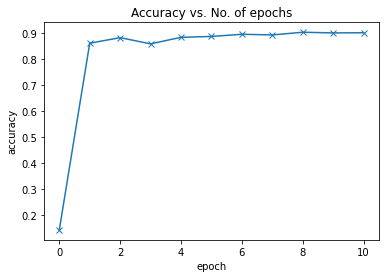

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

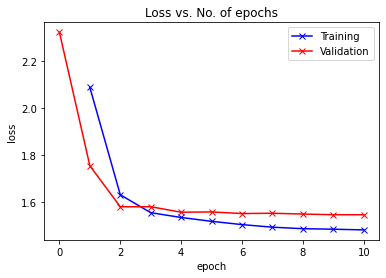

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

 **Non Pre-Trained Model Class**

In [23]:
class Resnet50_np(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [24]:
model = to_device(Resnet50_np(), device)
model

Resnet50_np(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [25]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.10635080933570862, 'val_loss': 2.436840295791626}]

**Training**

In [26]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [27]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 2.2896, val_loss: 2.2760, val_acc: 0.1402
Epoch [1], last_lr: 0.00008, train_loss: 2.2467, val_loss: 2.1798, val_acc: 0.1848
Epoch [2], last_lr: 0.00010, train_loss: 2.1495, val_loss: 2.1513, val_acc: 0.1954
Epoch [3], last_lr: 0.00010, train_loss: 2.1172, val_loss: 2.1390, val_acc: 0.2107
Epoch [4], last_lr: 0.00008, train_loss: 2.0931, val_loss: 2.0964, val_acc: 0.2497
Epoch [5], last_lr: 0.00006, train_loss: 2.0590, val_loss: 2.0550, val_acc: 0.2776
Epoch [6], last_lr: 0.00004, train_loss: 2.0326, val_loss: 2.0317, val_acc: 0.2954
Epoch [7], last_lr: 0.00002, train_loss: 2.0057, val_loss: 2.0103, val_acc: 0.3183
Epoch [8], last_lr: 0.00000, train_loss: 1.9885, val_loss: 1.9951, val_acc: 0.3364
Epoch [9], last_lr: 0.00000, train_loss: 1.9783, val_loss: 2.0001, val_acc: 0.3331
CPU times: user 3min 17s, sys: 1min 27s, total: 4min 44s
Wall time: 5min 26s


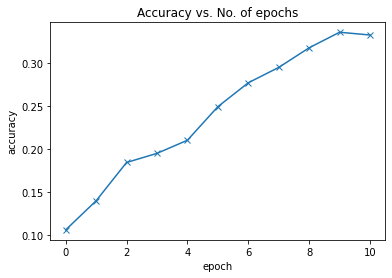

In [28]:
plot_accuracies(history)

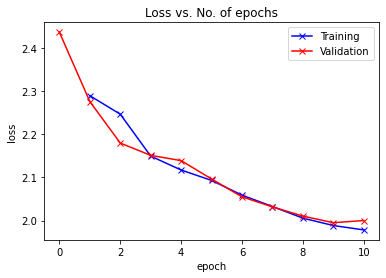

In [29]:
plot_losses(history)

**Conclusion** : From the above models, it is clear that with the help of pre-trained model **Resnet-50** we were able to generate a whooping accuracy of over 90% whereas without the pre-trained model,we were barely achieving a mere 30% accuracy which is totally unacceptable.